# 2nd Level Model Structure: Reactive Stage

In [1]:
import sys
import os
import pickle
sys.path.append(os.path.abspath('..'))
import numpy as np
from matplotlib import pyplot as plt

In [2]:
from pyomo import environ as pe
from global_sets.component import m
from utility.display_utility import trans_product_mole, trans_product_mass
from utility.model_utility import add_dual, update_dual, check_DOF

# stage construction rules
from physics.kinetics_bounded import kinetic_block_rule
from physics.energy_bounded import energy_block_rule
from physics.VLE_bounded import VLE_block_rule

model = pe.ConcreteModel()

# Global Sets (Inlet / Outlet)

In [3]:
model.inlet = pe.Set(initialize=['in'])
model.outlet = pe.Set(initialize=['out','P'])
model.stream = model.inlet | model.outlet

# Global Variables

In [4]:
# Tray Inlet/Outlet Variable
model.x_ = pe.Var(model.inlet,m.COMP_TOTAL,within=pe.NonNegativeReals)
model.y_ = pe.Var(model.inlet,m.COMP_TOTAL,within=pe.NonNegativeReals)
model.x = pe.Var(m.COMP_TOTAL,within=pe.NonNegativeReals)
model.y = pe.Var(m.COMP_TOTAL,within=pe.NonNegativeReals)
model.z = pe.Var(m.COMP_FEED,within=pe.NonNegativeReals)

model.L = pe.Var(model.stream,within=pe.NonNegativeReals)
model.V = pe.Var(model.stream,within=pe.NonNegativeReals)
model.F = pe.Var(within=pe.NonNegativeReals)

model.H_L_ = pe.Var(model.inlet,within=pe.Reals)
model.H_V_ = pe.Var(model.inlet,within=pe.Reals)
model.H_L = pe.Var(within=pe.Reals)
model.H_V = pe.Var(within=pe.Reals)
model.H_F = pe.Var(within=pe.Reals)

# State Variable
model.T = pe.Var(within=pe.NonNegativeReals,bounds=(200+273.15,300+273.15)) # K
model.T_F = pe.Var(within=pe.NonNegativeReals) # K
model.P = pe.Var(within=pe.NonNegativeReals,bounds=(10,30)) # Bar

model.f_V = pe.Var(m.COMP_TOTAL,within=pe.NonNegativeReals,initialize=1e-20)
model.f_L = pe.Var(m.COMP_TOTAL,within=pe.NonNegativeReals,initialize=1e-20)

model.cat = pe.Var(within=pe.NonNegativeReals) # kg
model.Q_main = pe.Var(within=pe.Reals) # MW
model.r_total_comp = pe.Var(m.COMP_TOTAL,within=pe.Reals) # kmol/s

# Construct Individual Blocks

In [5]:
model.kinetics_block = pe.Block(rule=kinetic_block_rule)

> Importing Kinetics Blocks......
> Adding the following local variable:
--------------------------------------------------
| kinetics_block.k_FT
| kinetics_block.r_FT_total
| kinetics_block.g0_FT
| kinetics_block.alpha
| kinetics_block.r_FT_cnum
| kinetics_block.r_FT_comp
| kinetics_block.k_WGS
| kinetics_block.Ke_WGS
| kinetics_block.r_WGS
| kinetics_block.r_WGS_comp
--------------------------------------------------



In [6]:
model.energy_block = pe.Block(rule=energy_block_rule)

> Importing Energy Blocks......
> Adding the following local variable:
--------------------------------------------------
| energy_block.dH_F
| energy_block.dH_V
| energy_block.dH_L
| energy_block.dH_vap
--------------------------------------------------



In [7]:
model.VLE_block = pe.Block(rule=VLE_block_rule)

> Importing VLE Blocks......
> Adding the following local variable:
--------------------------------------------------
| VLE_block.n_ave
| VLE_block.n_ave_cal
| VLE_block.Hen
| VLE_block.Hen0
| VLE_block.gamma
| VLE_block.P_sat
| VLE_block.P_sat_Y
| VLE_block.P_sat_dY_inf
| VLE_block.P_sat_dY0
| VLE_block.Hen_ref
| VLE_block.Hen0_ref
| VLE_block.gamma_ref
| VLE_block.V_L
| VLE_block.V_L_dY_inf
| VLE_block.V_L_dY0
| VLE_block.poynting
--------------------------------------------------



# Standard MESH Equations

## Mass Balance

\begin{equation}
Fz_{i}+\sum_{s\in{inlet}}L_{s}x'_{i,s}+\sum_{s\in{inlet}}V_{s}y'_{i,s}-\sum_{s\in{outlet}}L_{s}x_{i,s}+\sum_{s\in{ouelet}}V_{s}y_{i,s}+R_{i} = 0 \\
i = 1,...NC
\end{equation}

In [8]:
def mass_balance_main_rule(model,i):
    if i in m.COMP_FEED:
        return model.F*model.z[i] + sum(model.L[s]*model.x_[s,i] + model.V[s]*model.y_[s,i] for s in model.inlet)\
        + model.r_total_comp[i] - sum(model.L[s]*model.x[i] + model.V[s]*model.y[i] for s in model.outlet) == 0
    else:
        return sum(model.L[s]*model.x_[s,i] + model.V[s]*model.y_[s,i] for s in model.inlet)\
        + model.r_total_comp[i] - sum(model.L[s]*model.x[i] + model.V[s]*model.y[i] for s in model.outlet) == 0
model.mass_balance_main_con = pe.Constraint(m.COMP_TOTAL,rule=mass_balance_main_rule)

## Equilibrium

\begin{align}
&f_{i,V} = f_{i,L} \\
&i = 1,...NC
\end{align}

In [9]:
def VL_equil_rule(model,i):
    return model.f_V[i] == model.f_L[i]
model.VL_equil_con = pe.Constraint(m.COMP_TOTAL,rule=VL_equil_rule)

## Summation

\begin{equation}
\sum_ix_{i} = \sum_iy_{i} \\
F + L_{in} + V_{in} + R = L_{out} + V_{out}
\end{equation}

In [10]:
def summation_x_y_rule(model):
    return sum(model.x[i] for i in m.COMP_TOTAL) == sum(model.y[i] for i in m.COMP_TOTAL)
model.summation_x_y_con = pe.Constraint(rule=summation_x_y_rule)

def summation_total_mass_rule(model):
    return model.F + sum(model.L[s] + model.V[s] for s in model.inlet) + sum(model.r_total_comp[i] for i in m.COMP_TOTAL)\
            - sum(model.L[s] + model.V[s] for s in model.outlet) == 0
model.summation_total_mass_con = pe.Constraint(rule=summation_total_mass_rule)

## Energy Balance

\begin{equation}
F H_f+\sum_{s\in{inlet}}L_{s}H_{l,s}+\sum_{s\in{inlet}}V_{s}H_{v,s}-\sum_{s\in{outlet}}L_{s}H_{l,s}-\sum_{s\in{outlet}}V_{s}H_{v,s}+Q = 0
\end{equation}

In [11]:
def heat_balance_main_rule(model):
    return model.F*model.H_F + sum(model.L[s]*model.H_L_[s] + model.V[s]*model.H_V_[s] for s in model.inlet) \
            + model.Q_main - sum(model.L[s]*model.H_L + model.V[s]*model.H_V for s in model.outlet) == 0
model.heat_balance_main_con = pe.Constraint(rule=heat_balance_main_rule)

# Testing

In [12]:
add_dual(pe,model)

Created the follow pyomo suffixes:
ipopt_zL_out, ipopt_zU_out, ipopt_zL_in, ipopt_zU_in, dual


## Fixing In/Product Redundent Flow

In [13]:
model.x_.fix(0)
model.y_.fix(0)
model.L['in'].fix(0)
model.L['P'].fix(0)
model.V['in'].fix(0)
model.V['P'].fix(0)
model.H_L_.fix(0)
model.H_V_.fix(0)

## Fixing Model Parameters

In [14]:
model.cat.fix(300)
model.P.fix(20)
model.T_F.fix(200+273.15)
model.F.fix(1)
model.z['CO'].fix(1/(1+0.8)-0/2)
model.z['H2'].fix(0.8/(1+0.8)-0/2)
model.z['C30H62'].fix(0)
model.VLE_block.n_ave.fix(20)

In [15]:
check_DOF(pe,model)

Active Equality Constraints:	 1181
Active Inequality Constraints:	 0
Active Variables:		 1354
Fixed Variables:		 172
DOF:				 1


## Fix T or to fix Q? we have found that Maximize against an upper bound is most reliable

In [16]:
model.T.setub(300+273.15)

In [17]:
# model.obj = pe.Objective(expr = model.L['out'],sense=pe.maximize)
# model.obj = pe.Objective(expr = model.Q_main,sense=pe.maximize)
model.obj = pe.Objective(expr = model.T,sense=pe.maximize)

In [18]:
opt = pe.SolverFactory('ipopt')

opt.options['print_user_options'] = 'yes'
opt.options['linear_solver'] = 'ma86'

# opt.options['nlp_scaling_method'] = None
# opt.options['bound_relax_factor'] = 0
# opt.options['halt_on_ampl_error'] = 'yes'

opt.options['max_iter'] = 7000
results = opt.solve(model,tee=True)
update_dual(pe,model)

Ipopt 3.12.8: print_user_options=yes
linear_solver=ma86
max_iter=7000


List of user-set options:

                                    Name   Value                used
                           linear_solver = ma86                  yes
                                max_iter = 7000                  yes
                      print_user_options = yes                   yes

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.8, running with linear solver ma86.

Number of nonzeros in equality constraint Jacobian...:     3930
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.....

Overall NLP error.......:   1.4299940290056490e-10    1.3726056929952435e-08


Number of objective function evaluations             = 132
Number of objective gradient evaluations             = 60
Number of equality constraint evaluations            = 132
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 77
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 71
Total CPU secs in IPOPT (w/o function evaluations)   =      1.604
Total CPU secs in NLP function evaluations           =      0.062

EXIT: Optimal Solution Found.


In [19]:
model.Q_main.value

-29.150502201257197

In [20]:
model.T.value

518.6947446781547

In [21]:
# model.solutions.store_to(results)
# with open('../saved_solutions/reactive_flash_300C_n58.pickle','wb') as f:
#     pickle.dump(results,f)

In [22]:
print('Component\t\tLiquid: {:.4f}\t\t\tVapor: {:.4f}\t\t\tlog K'.format(model.L['out'].value,model.V['out'].value))
print('-'*108)
for i in model.x:
    print('{:10s}'.format(i),'\t\t{:8.4%}\t\t\t{:8.4%}\t\t\t{:.4f}'.format(model.x[i].value,model.y[i].value,np.log10(model.y[i].value/model.x[i].value)))

Component		Liquid: 0.0000			Vapor: 0.6977			log K
------------------------------------------------------------------------------------------------------------
H2         		 1.4510%			35.8280%			1.3926
CO         		 1.7945%			35.5618%			1.2970
CO2        		 2.2485%			21.0042%			0.9704
H2O        		 0.4244%			 2.0542%			0.6849
C2H4       		 0.0876%			 0.6600%			0.8771
C3H6       		 0.1627%			 0.6164%			0.5785
C4H8       		 0.1199%			 0.4447%			0.5691
C5H10      		 0.1463%			 0.2796%			0.2813
C6H12      		 0.1959%			 0.2123%			0.0349
C7H14      		 0.2470%			 0.1612%			-0.1853
C8H16      		 0.2986%			 0.1224%			-0.3873
C9H18      		 0.3502%			 0.0929%			-0.5762
C10H20     		 0.4013%			 0.0705%			-0.7550
C11H22     		 0.2878%			 0.0341%			-0.9260
C12H24     		 0.3193%			 0.0259%			-1.0907
C13H26     		 0.3500%			 0.0197%			-1.2502
C14H28     		 0.3799%			 0.0149%			-1.4055
C15H30     		 0.4090%			 0.0113%			-1.5571
C16H32     		 0.4371%			 0.0086%			-1.7056
C17H34     		 0.4644%			 0.0065%	

# Iterative Solve for Data Analysis

In [23]:
update_dual(pe,model)

In [24]:
opt.options['warm_start_init_point'] = 'yes'
opt.options['warm_start_bound_push'] = 1e-20
opt.options['warm_start_mult_bound_push'] = 1e-20
opt.options['mu_init'] = 1e-6

In [25]:
rf_data = {}
rf_data['r'] = {}; rf_data['T'] = []; rf_data['Q'] = []; rf_data['V'] = []; rf_data['L'] = []; 
rf_data['y_CO'] = []; rf_data['y_H2'] = []; rf_data['y_CO2'] = []; rf_data['y_H2O'] = []; rf_data['r_WGS'] = []; rf_data['r_FT'] = []
rf_data['f_V_CO'] = []; rf_data['f_V_H2'] = [];

for i in model.r_total_comp:
    rf_data['r'][i] = []
    
Trange = np.arange(300+273.15,199+273.15,-2)

for Tub in Trange:
    model.T.fix(Tub)
    results = opt.solve(model,tee=False)
    update_dual(pe,model)
    # print('-'*72)
    print('Solved, Solution T = {:.2f} K\t|\tV = {:.5f}\t|\tL = {:.5f}\t|'.format(model.T.value,model.V['out'].value,model.L['out'].value))
    # print('-'*72)
    rf_data['T'].append(model.T.value)
    rf_data['Q'].append(model.Q_main.value)
    rf_data['V'].append(model.V['out'].value)
    rf_data['L'].append(model.L['out'].value)    

    for i in model.r_total_comp:
        rf_data['r'][i].append(model.r_total_comp[i].value)
    
    
    rf_data['y_H2O'].append(model.y['H2O'].value)
    rf_data['y_CO'].append(model.y['CO'].value)
    rf_data['y_H2'].append(model.y['H2'].value)
    rf_data['y_CO2'].append(model.y['CO2'].value)
    rf_data['r_WGS'].append(model.kinetics_block.r_WGS.value)
    rf_data['r_FT'].append(model.kinetics_block.r_FT_total.value)
    
    rf_data['f_V_CO'].append(model.f_V['CO'].value)
    rf_data['f_V_H2'].append(model.f_V['H2'].value)

	message from solver=Ipopt 3.12.8\x3a Converged to a locally infeasible point. Problem may be infeasible.
Solved, Solution T = 573.15 K	|	V = 0.49999	|	L = 0.00000	|
	message from solver=Ipopt 3.12.8\x3a Converged to a locally infeasible point. Problem may be infeasible.
Solved, Solution T = 571.15 K	|	V = 0.48174	|	L = 0.00000	|
	message from solver=Ipopt 3.12.8\x3a Converged to a locally infeasible point. Problem may be infeasible.
Solved, Solution T = 569.15 K	|	V = 0.48270	|	L = 0.00000	|
	message from solver=Ipopt 3.12.8\x3a Converged to a locally infeasible point. Problem may be infeasible.
Solved, Solution T = 567.15 K	|	V = 0.50323	|	L = 0.00000	|
	message from solver=Ipopt 3.12.8\x3a Converged to a locally infeasible point. Problem may be infeasible.
Solved, Solution T = 565.15 K	|	V = 0.48537	|	L = 0.00000	|
	message from solver=Ipopt 3.12.8\x3a Converged to a locally infeasible point. Problem may be infeasible.
Solved, Solution T = 563.15 K	|	V = 0.48713	|	L = 0.00000	|
	mes

## Some Observations

* This system has multiple solution under same Q.
* The reaction rate peaks at ~530K, due to decreasing $\alpha$, increasing light component, uses up more feed.
* Note that when 'fully' utilizing catalyst, the system seems to always require cooling.

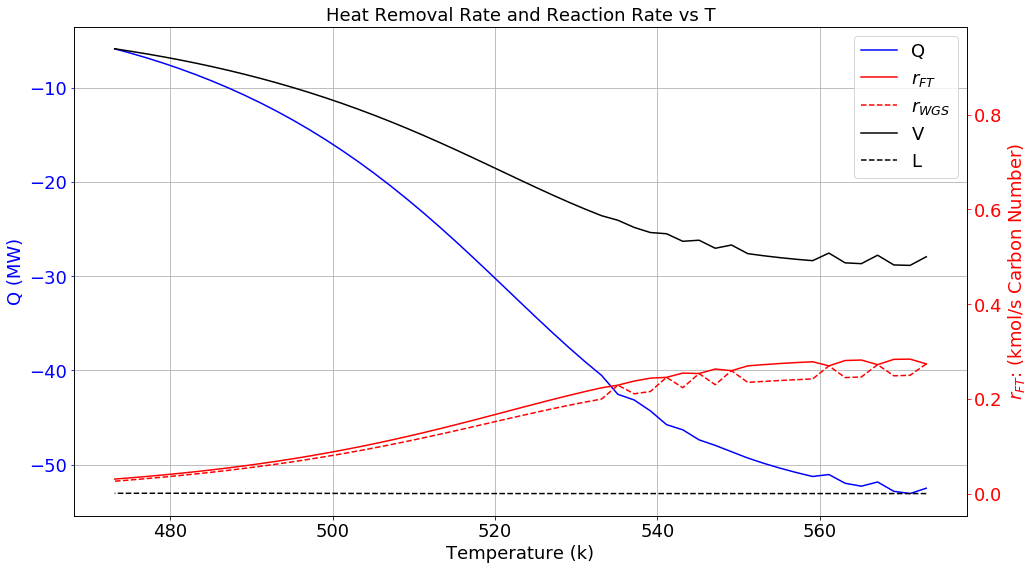

In [26]:
fig, ax1 = plt.subplots(figsize=(16,9))
line1 = ax1.plot(rf_data['T'],rf_data['Q'], 'b-')
ax1.set_xlabel('Temperature (k)', color='K',fontsize=18)
ax1.set_ylabel('Q (MW)', color='b',fontsize=18)
ax1.tick_params('y', colors='b',labelsize=18)
ax1.tick_params('x', colors='k',labelsize=18)
ax1.grid()

ax2 = ax1.twinx()
line2 = ax2.plot(rf_data['T'],rf_data['r_FT'], 'r')
line3 = ax2.plot(rf_data['T'],rf_data['r_WGS'], 'r--')
line4 = ax2.plot(rf_data['T'],rf_data['V'], 'k')
line5 = ax2.plot(rf_data['T'],rf_data['L'], 'k--')
ax2.set_ylabel('$r_{FT}$: (kmol/s Carbon Number)', color='r',fontsize=18)
ax2.tick_params('y', colors='r',labelsize=18)

ax1.legend(line1+line2+line3+line4+line5,['Q','$r_{FT}$','$r_{WGS}$','V','L'],fontsize=18,loc=1)
ax1.set_title('Heat Removal Rate and Reaction Rate vs T',fontsize=18)
plt.show()

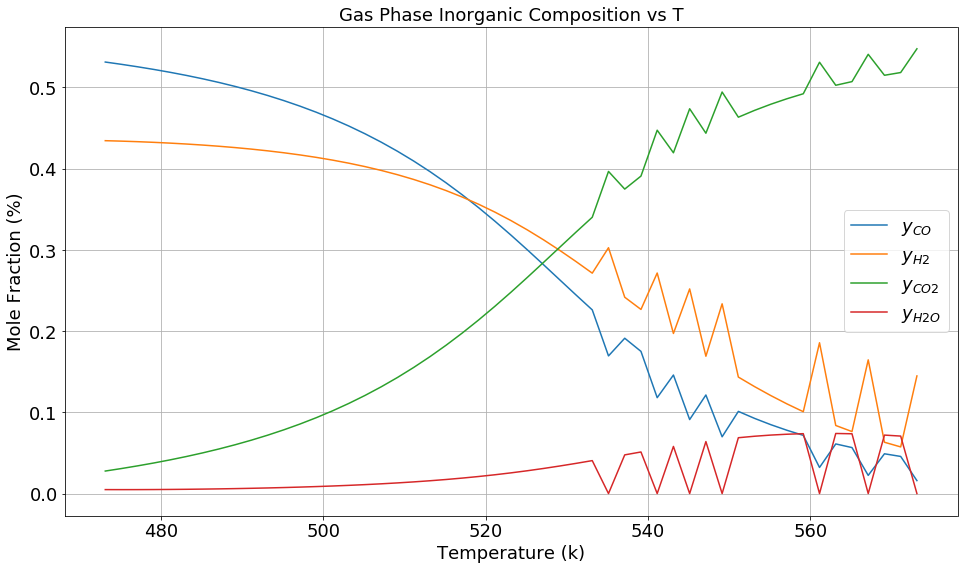

In [27]:
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(rf_data['T'],rf_data['y_CO'])
ax.plot(rf_data['T'],rf_data['y_H2'])
ax.plot(rf_data['T'],rf_data['y_CO2'])
ax.plot(rf_data['T'],rf_data['y_H2O'])

ax.legend(['$y_{CO}$','$y_{H2}$','$y_{CO2}$','$y_{H2O}$'],fontsize=18)
ax.set_title('Gas Phase Inorganic Composition vs T',fontsize=18)

ax.set_ylabel('Mole Fraction (%)', color='K',fontsize=18)
ax.set_xlabel('Temperature (k)', color='K',fontsize=18)
ax.tick_params('y', colors='k',labelsize=18)
ax.tick_params('x', colors='k',labelsize=18)
ax.grid()
plt.show()

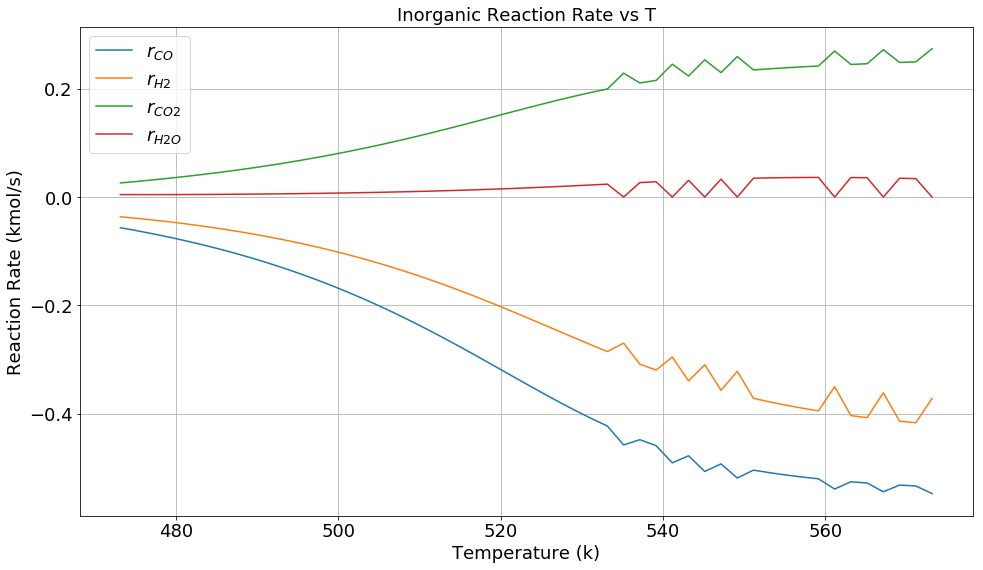

In [28]:
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(rf_data['T'],rf_data['r']['CO'])
ax.plot(rf_data['T'],rf_data['r']['H2'])
ax.plot(rf_data['T'],rf_data['r']['CO2'])
ax.plot(rf_data['T'],rf_data['r']['H2O'])

ax.legend(['$r_{CO}$','$r_{H2}$','$r_{CO2}$','$r_{H2O}$'],fontsize=18)
ax.set_title('Inorganic Reaction Rate vs T',fontsize=18)

ax.set_ylabel('Reaction Rate (kmol/s)', color='K',fontsize=18)
ax.set_xlabel('Temperature (k)', color='K',fontsize=18)
ax.tick_params('y', colors='k',labelsize=18)
ax.tick_params('x', colors='k',labelsize=18)
ax.grid()
plt.show()

## Product Distribution (mole)

In [29]:
reaction_data = trans_product_mole(rf_data['r'])['unscaled']
reaction_data_scaled = trans_product_mole(rf_data['r'])['scaled']

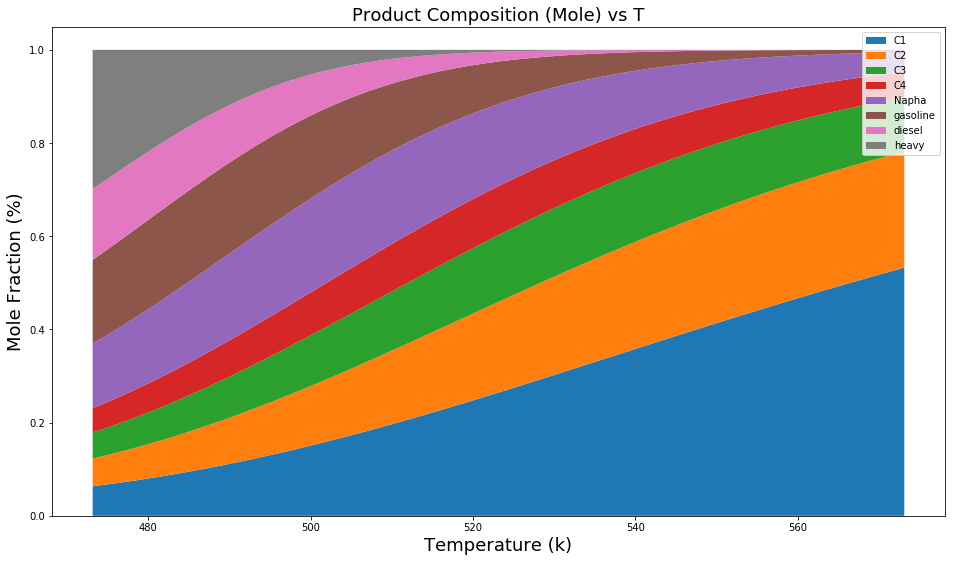

In [30]:
fig, ax = plt.subplots(figsize=(16,9))
ax.stackplot(rf_data['T'], reaction_data_scaled['c1'], reaction_data_scaled['c2'],reaction_data_scaled['c3'],reaction_data_scaled['c4'],\
            reaction_data_scaled['napha'],reaction_data_scaled['gasoline'],reaction_data_scaled['diesel'],reaction_data_scaled['heavy'])
plt.legend(['C1','C2','C3','C4','Napha','gasoline','diesel','heavy'])
ax.set_title('Product Composition (Mole) vs T',fontsize=18)
ax.set_ylabel('Mole Fraction (%)', color='K',fontsize=18)
ax.set_xlabel('Temperature (k)', color='K',fontsize=18)
plt.show()

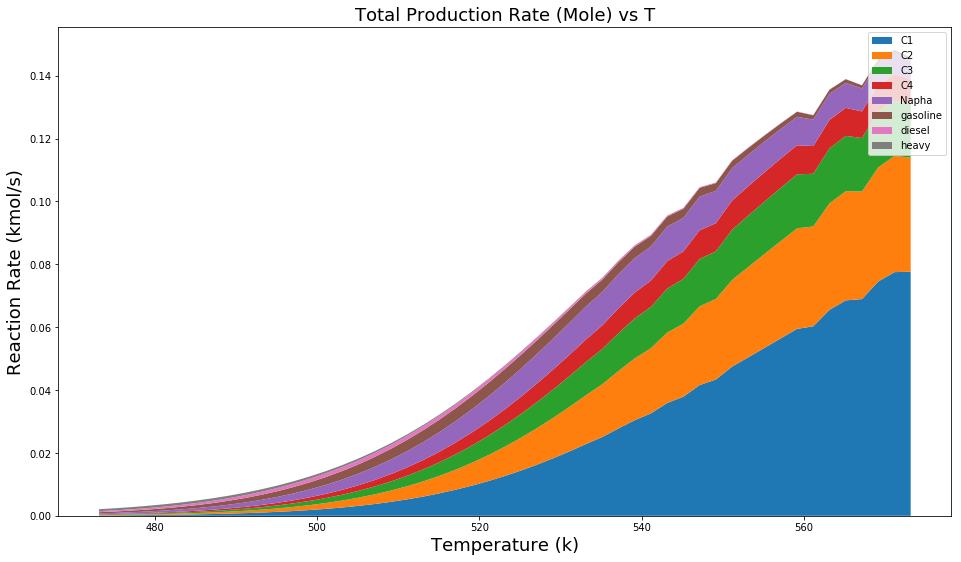

In [31]:
fig, ax = plt.subplots(figsize=(16,9))
ax.stackplot(rf_data['T'], reaction_data['c1'], reaction_data['c2'],reaction_data['c3'],reaction_data['c4'],\
            reaction_data['napha'],reaction_data['gasoline'],reaction_data['diesel'],reaction_data['heavy'])
plt.legend(['C1','C2','C3','C4','Napha','gasoline','diesel','heavy'])
ax.set_title('Total Production Rate (Mole) vs T',fontsize=18)
ax.set_ylabel('Reaction Rate (kmol/s)', color='K',fontsize=18)
ax.set_xlabel('Temperature (k)', color='K',fontsize=18)
plt.show()

## Product Distribution (mass)

In [32]:
mass_reaction_data = trans_product_mass(rf_data['r'])['unscaled']
mass_reaction_scaled = trans_product_mass(rf_data['r'])['scaled']

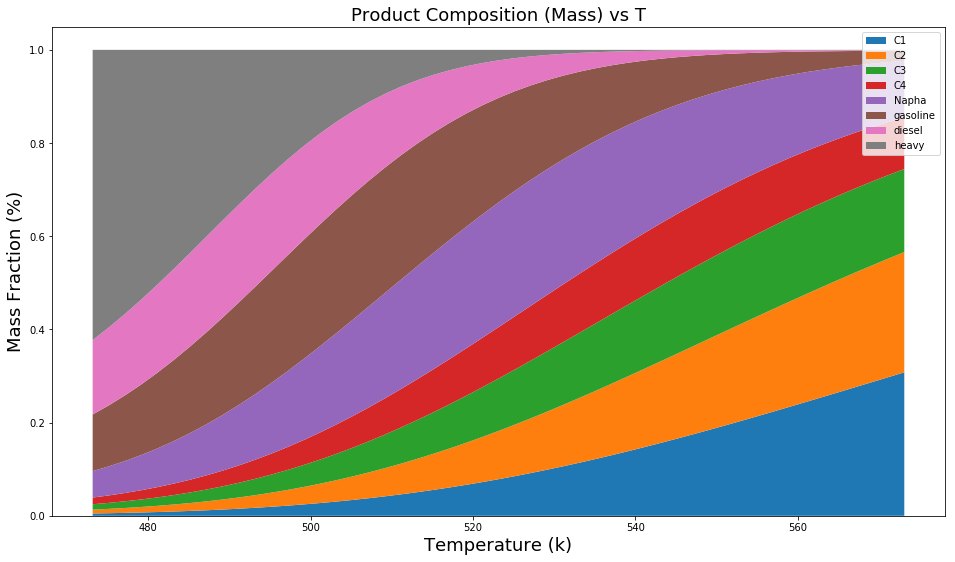

In [33]:
fig, ax = plt.subplots(figsize=(16,9))
ax.stackplot(rf_data['T'], mass_reaction_scaled['c1'], mass_reaction_scaled['c2'],mass_reaction_scaled['c3'],mass_reaction_scaled['c4'],\
            mass_reaction_scaled['napha'],mass_reaction_scaled['gasoline'],mass_reaction_scaled['diesel'],mass_reaction_scaled['heavy'])
plt.legend(['C1','C2','C3','C4','Napha','gasoline','diesel','heavy'])
ax.set_title('Product Composition (Mass) vs T',fontsize=18)
ax.set_ylabel('Mass Fraction (%)', color='K',fontsize=18)
ax.set_xlabel('Temperature (k)', color='K',fontsize=18)
plt.show()

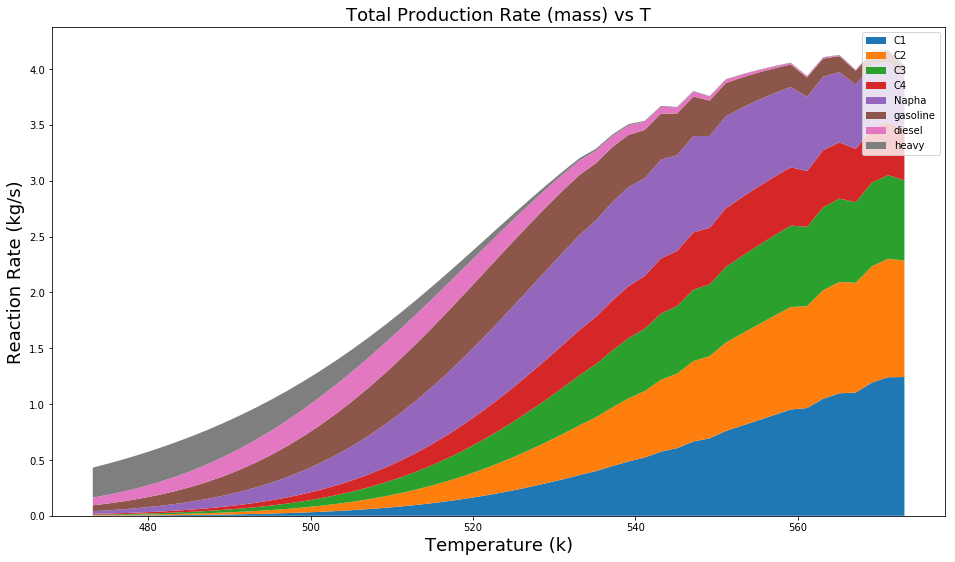

In [34]:
fig, ax = plt.subplots(figsize=(16,9))
ax.stackplot(rf_data['T'], mass_reaction_data['c1'], mass_reaction_data['c2'],mass_reaction_data['c3'],mass_reaction_data['c4'],\
            mass_reaction_data['napha'],mass_reaction_data['gasoline'],mass_reaction_data['diesel'],mass_reaction_data['heavy'])
plt.legend(['C1','C2','C3','C4','Napha','gasoline','diesel','heavy'])
ax.set_title('Total Production Rate (mass) vs T',fontsize=18)
ax.set_ylabel('Reaction Rate (kg/s)', color='K',fontsize=18)
ax.set_xlabel('Temperature (k)', color='K',fontsize=18)
plt.show()

In [35]:
# model.solutions.store_to(results)
# with open('../saved_solutions/reactive_flash_200C_n58.pickle','wb') as f:
#     pickle.dump(results,f)

# VLE Validation using AspenPlus

### Feed (Reactor Effluent)

In [36]:
print('Temperature (C): \t{:.2f}\t\t'.format(model.T.value-273.15))
print('Conversion(H2+CO): \t{:.2f}\t\t'.format(1-((model.y['CO'].value+model.y['H2'].value)*model.V['out'].value)))
print('Total FLow (kmol/s): \t{:.2f}\t\t'.format(model.L['out'].value+model.V['out'].value))
print('-'*72)
for i in model.x:
    print('{:10s}'.format(i),'\t\t{:.4%}'.format((model.x[i].value*model.L['out'].value\
        +model.y[i].value*model.V['out'].value)/(model.L['out'].value+model.V['out'].value)))

Temperature (C): 	200.00		
Conversion(H2+CO): 	0.09		
Total FLow (kmol/s): 	0.94		
------------------------------------------------------------------------
H2         		43.4206%
CO         		53.0986%
CO2        		2.7711%
H2O        		0.4865%
C2H4       		0.0086%
C3H6       		0.0100%
C4H8       		0.0089%
C5H10      		0.0069%
C6H12      		0.0065%
C7H14      		0.0061%
C8H16      		0.0057%
C9H18      		0.0054%
C10H20     		0.0050%
C11H22     		0.0030%
C12H24     		0.0028%
C13H26     		0.0026%
C14H28     		0.0025%
C15H30     		0.0023%
C16H32     		0.0022%
C17H34     		0.0021%
C18H36     		0.0019%
C19H38     		0.0018%
C20H40     		0.0017%
C1H4       		0.0141%
C2H6       		0.0046%
C3H8       		0.0025%
C4H10      		0.0028%
C5H12      		0.0041%
C6H14      		0.0038%
C7H16      		0.0036%
C8H18      		0.0034%
C9H20      		0.0032%
C10H22     		0.0030%
C11H24     		0.0045%
C12H26     		0.0042%
C13H28     		0.0040%
C14H30     		0.0037%
C15H32     		0.0035%
C16H34     		0.0033%
C17H36     		0.0031%
C1

### Phase Separation

In [37]:
print('Component\t\tLiquid: {:.4f}\t\t\tVapor: {:.4f}\t\t\tlog K'.format(model.L['out'].value,model.V['out'].value))
print('-'*108)
for i in model.x:
    print('{:10s}'.format(i),'\t\t{:8.4%}\t\t\t{:8.4%}\t\t\t{:.4f}'.format(model.x[i].value,model.y[i].value,np.log10(model.y[i].value/model.x[i].value)))

Component		Liquid: 0.0006			Vapor: 0.9390			log K
------------------------------------------------------------------------------------------------------------
H2         		 1.5180%			43.4457%			1.4567
CO         		 2.4813%			53.1290%			1.3307
CO2        		 0.3241%			 2.7726%			0.9322
H2O        		 0.1414%			 0.4867%			0.5370
C2H4       		 0.0013%			 0.0086%			0.8302
C3H6       		 0.0033%			 0.0100%			0.4829
C4H8       		 0.0034%			 0.0089%			0.4221
C5H10      		 0.0054%			 0.0069%			0.1104
C6H12      		 0.0095%			 0.0065%			-0.1641
C7H14      		 0.0158%			 0.0061%			-0.4151
C8H16      		 0.0254%			 0.0057%			-0.6499
C9H18      		 0.0398%			 0.0053%			-0.8729
C10H20     		 0.0610%			 0.0050%			-1.0869
C11H22     		 0.0585%			 0.0030%			-1.2939
C12H24     		 0.0866%			 0.0028%			-1.4952
C13H26     		 0.1265%			 0.0026%			-1.6918
C14H28     		 0.1822%			 0.0024%			-1.8847
C15H30     		 0.2584%			 0.0022%			-2.0743
C16H32     		 0.3599%			 0.0020%			-2.2611
C17H34     		 0.4909%			 0.0018%